傅立葉 -> 色相反轉

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#------------------------------------------------------
def notch_reject_filter(shape, d0=9, x=0, y=0):
    """
    建立 Notch Reject 濾波器。
    濾波器會針對頻譜中的某一區域及其對稱點進行屏蔽。

    Parameters:
    - shape: 影像的大小 (rows, cols)
    - d0: 半徑大小，控制濾波範圍
    - x, y: 濾波器中心點，使用左上角 (0, 0) 為基準的座標

    Returns:
    - H: Notch 濾波器 (2D numpy array)
    """
    P, Q = shape
    H = np.ones((P, Q))  # 初始化為全通濾波器 (值為1)

    # 將座標轉換到頻譜中心
    u_k = x - Q / 2
    v_k = y - P / 2

    # 針對頻譜每個點計算距離，決定是否濾波
    for v in range(P):
        for u in range(Q):
            # 計算距離 (針對目標頻率點和對稱頻率點)
            D_uv = np.sqrt((v - P / 2 + v_k) ** 2 + (u - Q / 2 + u_k) ** 2)
            D_muv = np.sqrt((v - P / 2 - v_k) ** 2 + (u - Q / 2 - u_k) ** 2)

            # 如果在半徑範圍內，設為0 (濾波區域)
            if D_uv <= d0 or D_muv <= d0:
                H[v, u] = 0.0

    return H
#-------------------------

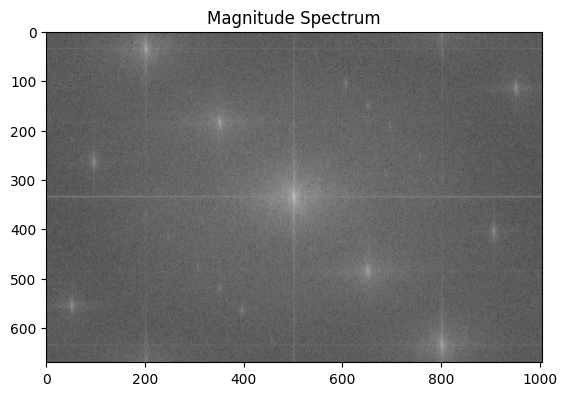

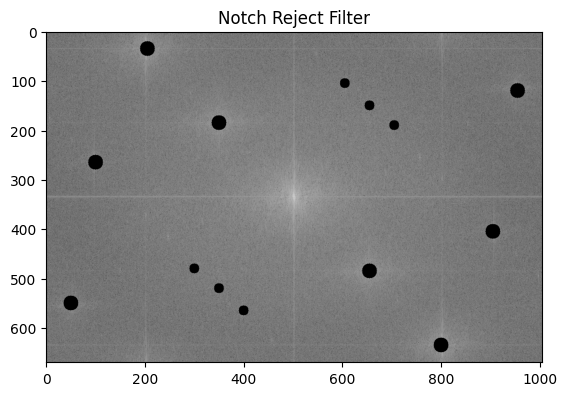

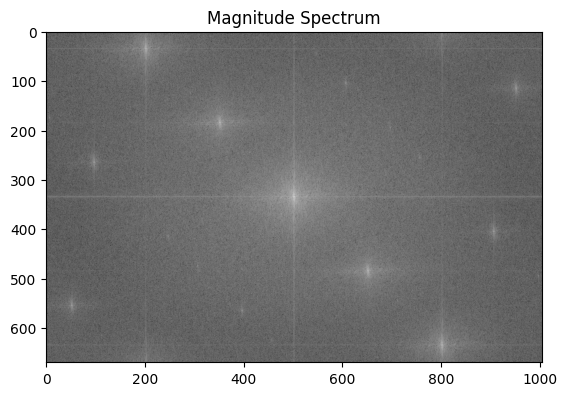

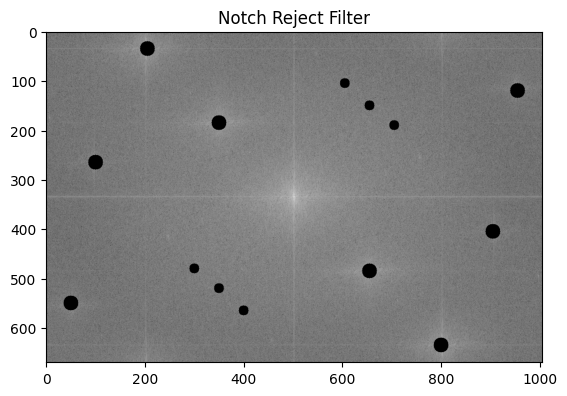

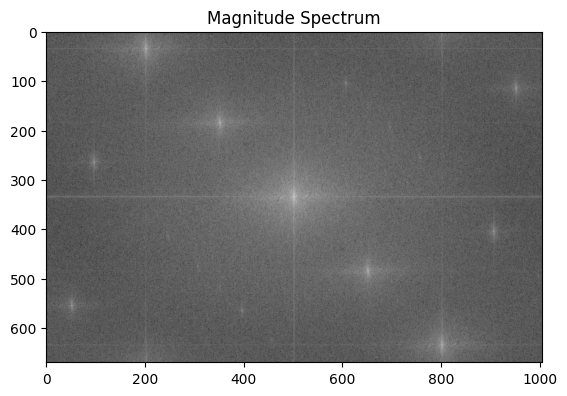

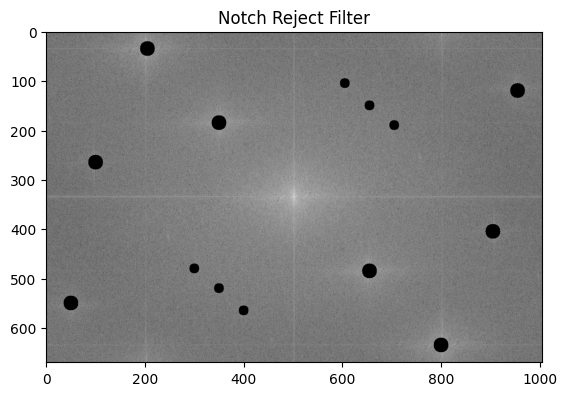

In [3]:
# 1. 讀取影像
img = cv2.imread('04_image.jpg')
b,g,r = cv2.split(img)
result = []

for channel in [b,g,r]:
    # 2. 進行傅立葉轉換，轉換到頻域
    f = np.fft.fft2(channel)  # 計算傅立葉變換
    fshift = np.fft.fftshift(f)  # 將低頻移到中心位置
    magnitude_spectrum = 20 * np.log(np.abs(fshift))  # 計算頻譜 (取對數以增強可視化效果)

    # 頻譜圖
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'Magnitude Spectrum')
    plt.show()

    # 3. 獲取影像尺寸
    img_shape = channel.shape

    filters = []
    # 4. 設計 Notch 濾波器，針對特定頻率區域屏蔽
    filters.append(notch_reject_filter(img_shape, d0=15, x=100, y=265))
    filters.append(notch_reject_filter(img_shape, d0=15, x=50, y=550))
    filters.append(notch_reject_filter(img_shape, d0=15, x=205, y=35))
    filters.append(notch_reject_filter(img_shape, d0=15, x=350, y=185))
    filters.append(notch_reject_filter(img_shape, d0=10, x=400, y=565))
    filters.append(notch_reject_filter(img_shape, d0=10, x=350, y=520))
    filters.append(notch_reject_filter(img_shape, d0=10, x=300, y=480))
    # filters.append(notch_reject_filter(img_shape, d0=10, x=240, y=410))
    # filters.append(notch_reject_filter(img_shape, d0=10, x=200, y=380))
    # filters.append(notch_reject_filter(img_shape, d0=10, x=205, y=635))
    # filters.append(notch_reject_filter(img_shape, d0=10, x=505, y=40))


    notch_size = img_shape
    NotchFilter = np.ones(notch_size)  # 初始化為全通濾
    # 5. 合併多個濾波器
    for filter in filters:
        NotchFilter *=filter# 將多個濾波器相乘，覆蓋多個區域

    # 6. 應用濾波器，濾除選定頻率
    NotchRejectCenter = fshift * NotchFilter  # 在頻域乘上濾波器
    NotchReject = np.fft.ifftshift(NotchRejectCenter)  # 反向位移，將頻譜移回原位置
    inverse_NotchReject = np.fft.ifft2(NotchReject)  # 進行逆傅立葉變換
    result.append(np.abs(inverse_NotchReject)) # 計算結果影像的幅值

    # 濾波器作用後的頻譜
    plt.imshow(magnitude_spectrum * NotchFilter, cmap="gray")
    plt.title("Notch Reject Filter")
    plt.show()


In [8]:
# 合併色彩
filtered_color_img = cv2.merge(result)
# 7.3. 轉換為 8 位元整數 (可顯示的標準影像格式)
filtered_color_img_uint8 = np.uint8(filtered_color_img)
# 儲存結果
cv2.imwrite("filtered_image_result.jpg", filtered_color_img_uint8)

True

In [9]:
# 色彩反轉
img_negative = cv2.bitwise_not(filtered_color_img_uint8)
cv2.imwrite("filtered_image_negative_result.jpg", img_negative)

True